In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.metrics import roc_auc_score
from geopy.distance import vincenty
sns.set_style("darkgrid")

In [2]:
%%javascript
$('.nbp-app-bar').toggle()

<IPython.core.display.Javascript object>

# But what about the holdout `test.csv` data?

In [23]:
path = '../kaggle_data/input/'
test = pd.read_csv(path+'test.csv')
weather=pd.read_csv('weather2.csv')
holdout=pd.merge(test, weather, on='Date');
print(holdout.shape)
holdout.head(1)

(116293, 15)


,Id,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,avg_rain1,avg_rain2,avg_dry1,avg_dry2
0,1,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,1.0,0.571429,0.142857,0.714286


In [4]:
# Reduce the species categorical variable to just 4 categories
holdout['CULEX']='ALTER'
holdout.loc[(holdout['Species']=='CULEX PIPIENS/RESTUANS') , 'CULEX']='PIPIENS-RESTUANS'
holdout.loc[(holdout['Species']=='CULEX RESTUANS') , 'CULEX']='RESTUANS'
holdout.loc[(holdout['Species']=='CULEX PIPIENS') , 'CULEX']='PIPIENS'
holdout['CULEX'].value_counts()
# Dummify the Species
dummies=pd.get_dummies(holdout['CULEX'])
holdout=pd.concat([holdout, dummies], axis=1)

In [5]:
# Let's convert date/time into something usable. 
holdout['Month']=holdout['Date'].str.split('-').str[1].astype(str)
holdout['Year']=holdout['Date'].str.split('-').str[0].astype(int)
# Day of the year
holdout['DayRunner']=pd.to_datetime(holdout['Date']).dt.dayofyear

#### Calculate distance from virus hotspots.

In [6]:
# Create a lat-long variable that's a tuple.
holdout['lat_long'] = list(zip(holdout['Latitude'], holdout['Longitude']))

In [7]:
# Bring in the list of virus hotspots from the training data.
import pickle
with open('top_hots.pickle', 'rb') as f:
    top_hots = pickle.load(f)

In [8]:
# Calculate the distances
hot_list=[]
for x in range(30):
    digit=str(x)
    holdout['to_hotspot'+digit]=holdout['lat_long'].apply(lambda row: vincenty(row, top_hots[x]).miles)
    
    # Create an indicator if a row is less than 1 mile from one of the virus hotspots
    holdout['flag_hotspot'+digit]=holdout['to_hotspot'+digit].apply(lambda row: row<1).astype(int)
    hot_list.append('flag_hotspot'+digit)

# Summarize those indicators.
holdout['near_hotspot'] = holdout[hot_list].sum(axis=1)
holdout['near_hotspot'].describe()

count    116293.000000
mean          0.461472
std           0.750770
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           4.000000
Name: near_hotspot, dtype: float64

In [9]:
# Did this do what we wanted it to? Let's check out that max. It's near the airport! Nice!
holdout[holdout['near_hotspot']==4].head(1)

,Id,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,...,flag_hotspot25,to_hotspot26,flag_hotspot26,to_hotspot27,flag_hotspot27,to_hotspot28,flag_hotspot28,to_hotspot29,flag_hotspot29,near_hotspot
144,145,2008-06-11,"9100 West Higgins Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,91,W HIGGINS AVE,T009,"9100 W HIGGINS AVE, Chicago, IL",41.981964,-87.812827,...,0,2.556767,0,15.117775,0,21.180922,0,14.247395,0,4


#### Mapping Distance from Spots with a High Number of Mosquitos

In [10]:
# Bring in the list of virus hotspots from the training data.
import pickle
with open('top_chomps.pickle', 'rb') as f:
    top_chomps = pickle.load(f)

In [11]:
# Do the same thing for its distance from the 20 spots with highest average mosquito count.
chomp_list=[]
for x in range(30):
    digit=str(x)
    holdout['to_chompspot'+digit]=holdout['lat_long'].apply(lambda row: vincenty(row, top_chomps[x]).miles)   

    # Create an indicator if a row is less than 2 miles from one of the high-mosquito-count chompspots
    holdout['flag_chompspot'+digit]=holdout['to_chompspot'+digit].apply(lambda row: row<2).astype(int)
    chomp_list.append('flag_chompspot'+digit)

holdout['near_chompspot'] = holdout[chomp_list].sum(axis=1)
holdout['near_chompspot'].describe()

count    116293.000000
mean          1.271951
std           1.262775
min           0.000000
25%           0.000000
50%           1.000000
75%           2.000000
max           6.000000
Name: near_chompspot, dtype: float64

In [12]:
# Create a "drop" list of (nearly) all the variables we just created 
drop_list=[]
for x in range(30):
    digit=str(x)
    drop_list.append('to_hotspot'+digit)
    drop_list.append('flag_hotspot'+digit)
    drop_list.append('to_chompspot'+digit)
    drop_list.append('flag_chompspot'+digit)
# Drop them because they are no longer necessary.
holdout=holdout.drop(hot_list + chomp_list + drop_list, axis=1)

### Make sure that our `holdout` dataset has the correct feature list

In [13]:
# Should be eleven columns.
holdout_trim=holdout.drop(['Id', 'Date', 'Address', 'Species', 'Block', 'Street', 'Trap',
       'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy', 
              'CULEX', 'Month', 'Year', 'lat_long',], axis=1)
print(len(holdout_trim.columns))
print(holdout_trim.columns)

11
Index(['avg_rain1', 'avg_rain2', 'avg_dry1', 'avg_dry2', 'ALTER', 'PIPIENS',
       'PIPIENS-RESTUANS', 'RESTUANS', 'DayRunner', 'near_hotspot',
       'near_chompspot'],
      dtype='object')


## Import the pickled RF model from the previous `ipynb`.

In [14]:
import pickle
with open('tree_model.pickle', 'rb') as f:
    tree_model = pickle.load(f)

In [30]:
# Predict on the holdout data.
y_hat = tree_model.predict(holdout_trim)
y_hat_probs = tree_model.predict_proba(holdout_trim)[:,1]

In [16]:
# # Just grab the second column for Kaggle submission.
# predictions = pd.DataFrame(y_hat_probs, columns=['Predicted'])
# print(len(predictions))
# predictions.describe()

116293


,Predicted
count,116293.000000
mean,0.030441
std,0.008870
min,0.011444
25%,0.024777
50%,0.030042
75%,0.034673
max,0.056769


## Kaggle Submission

In [29]:
print(predictions.head())
print(predictions.tail())
print(len(predictions))
predictions

   Predicted
0   0.022946
1   0.012589
2   0.031999
3   0.019062
4   0.019062
        Predicted
116288   0.019062
116289   0.019062
116290   0.019062
116291   0.019062
116292   0.019062
116293


,Predicted
0,0.022946
1,0.012589
2,0.031999
3,0.019062
4,0.019062
5,0.019062
6,0.019062
7,0.019062
8,0.030955
9,0.017470


In [27]:
len(holdout['Id'])

116293

In [34]:
submission=pd.DataFrame(list(zip(holdout['Id'], y_hat_probs)), columns=['Id','WnvPresent'])
print(submission['WnvPresent'].describe())
submission.tail(3)

count    116293.000000
mean          0.030441
std           0.008870
min           0.011444
25%           0.024777
50%           0.030042
75%           0.034673
max           0.056769
Name: WnvPresent, dtype: float64


,Id,WnvPresent
116290,116291,0.019062
116291,116292,0.019062
116292,116293,0.019062


In [ ]:
dirname = '../Austin/'
submission.to_csv(dirname + 'submission.csv', index=False)

### https://www.kaggle.com/c/predict-west-nile-virus/submit

In [ ]:
submission['WnvPresent'].mean()

I think I'm doing something wrong here.
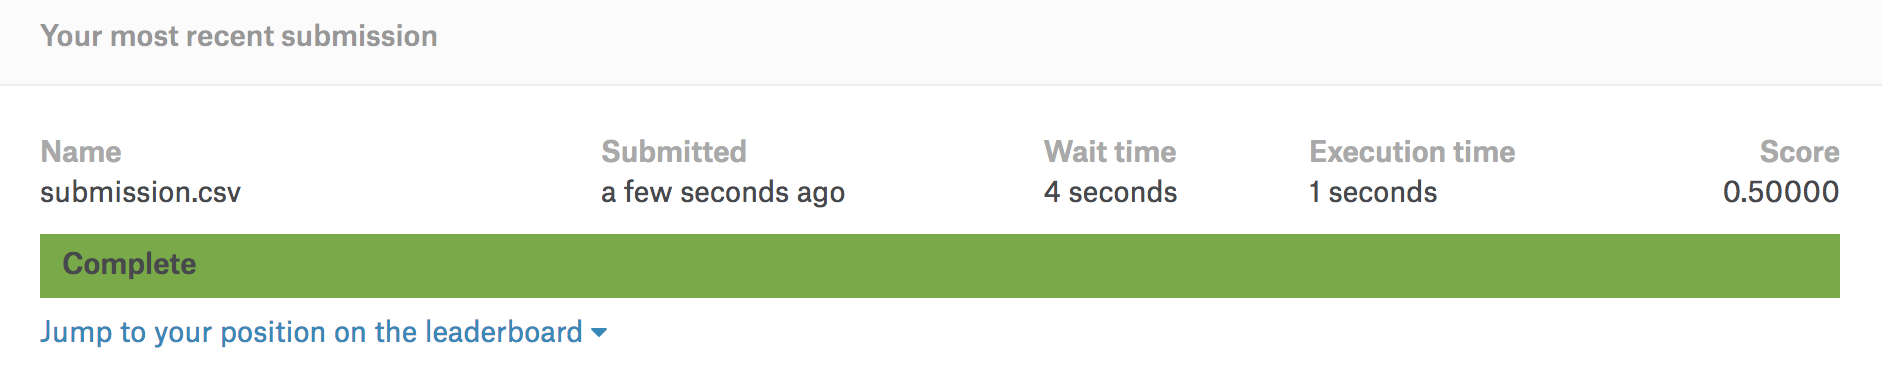

My train-test AUC-ROC was so high! But here it's just .50.